In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

np.random.seed(123)

In [2]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    df = pd.read_sql(my_query, get_connection('titanic_db'))
    return df

In [3]:
df = get_titanic()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [4]:
df.isna().mean()

passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
dtype: float64

In [5]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df

In [6]:
df = prep_titanic(df)
df.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,S,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,1,0,0


## are we going to do any modelling? yes?  we split our data at this point

## notice all the univariate exploration (the charts) are on the train dataset only!

In [7]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [8]:
train, validate, test = train_validate_test_split(df, target='survived')
train.shape, validate.shape, test.shape

((398, 12), (171, 12), (143, 12))

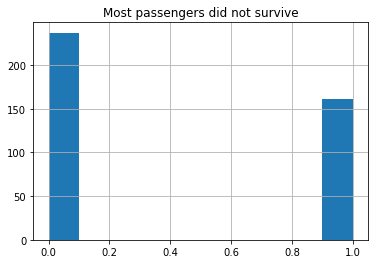

In [9]:
plt.title("Most passengers did not survive")
train.survived.hist()
plt.show()

# notice how Ryan made the title of the graph the main 'takeaway' he wants to stay with you

In [10]:
# We can call .mean() since 0 and 1 are numeric
print("Percent survived from train")
round(train.survived.mean(), 3)

Percent survived from train


0.405

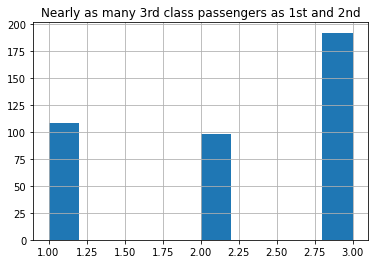

In [11]:
plt.title("Nearly as many 3rd class passengers as 1st and 2nd")
train.pclass.hist()
plt.show()

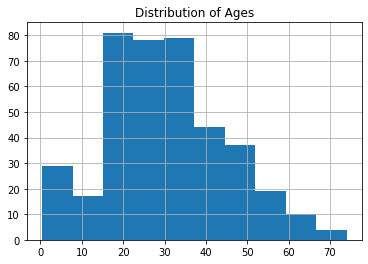

In [12]:
plt.title("Distribution of Ages")
train.age.hist()
plt.show()

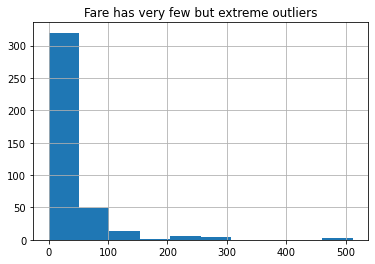

In [13]:
plt.title("Fare has very few but extreme outliers")
train.fare.hist()
plt.show()

## are we going to have to deal with those outlying fares?

## there are different tests for different distributions--see curiculum.  

In [14]:
#mann-whitney instead of t-test, for example

# next, bivariate

## if you use y/n (1/0) for the y axis, you're basically giving yourself the percentage.  take note below

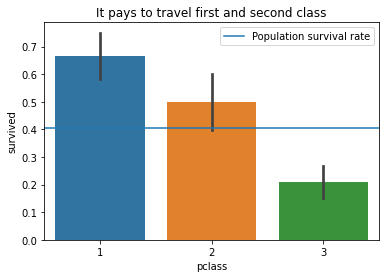

In [15]:
plt.title("It pays to travel first and second class")
sns.barplot(x="pclass", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

### hypothesis test immediately following, for thoroughness's sake:

In [16]:
# The above visual is quite clear, but if it was less clear or we want more certainty, we'll run a hypothesis test
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "survival and class of ticket are independent"
alternative_hypothesis = "there is a relationship between class of ticket and survival"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.pclass)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and class of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between class of ticket and survival


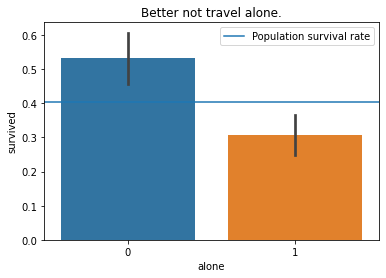

In [17]:
plt.title("Better not travel alone.")
sns.barplot(x="alone", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [18]:
# Ryan runs a t-test on this one as well, in the curriculum

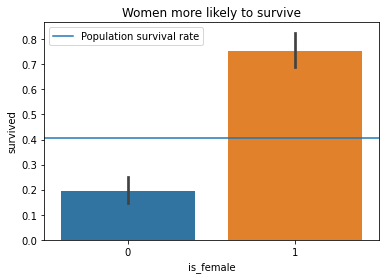

In [19]:
plt.title("Women more likely to survive")
sns.barplot(x="is_female", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [20]:
# t-test here

## numeric vs categorical

H
0
: Survived passenger fares cost less than or equal to non-surviving passenger fare

H
a
: Surviving passenger fares cost more than non-surviving passenger fares

In [21]:
not_survived = train[train.survived == 0]
survived = train[train.survived == 1]

In [22]:
not_survived.fare.var(), survived.fare.var()

(846.4473286218973, 7299.474755819128)

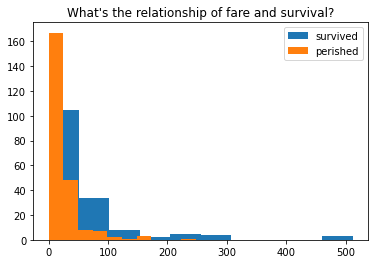

In [24]:
plt.title("What's the relationship of fare and survival?")
plt.hist(survived.fare, label="survived")
plt.hist(not_survived.fare, label="perished")
plt.legend()
plt.show()

#plain matplotlib
# the story is unclear from the visual, so a hypothesis test should be run

In [27]:
from scipy import stats

null_hypothesis = "fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers"
alternative_hypothesis = "fares paid by surviving passengers are higher than non-surviving passengers"

# Use Mann Whitney u-test when t-test assumptions do not hold.
# The distributions are not normal and the variances are not equal, so we'll do mann-whitney
t, p = stats.mannwhitneyu(survived.fare, not_survived.fare, alternative="greater")
# alternative argument handles the directionality. b/c of this argument, we don't have to check if t is + or -

In [28]:
if p < alpha:
    print("We find evidence to reject the null hypothesis that", null_hypothesis)
    print("We find evidence evidence to move forward with the understaind that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("There is no evidence that", null_hypothesis)

We find evidence to reject the null hypothesis that fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers
We find evidence evidence to move forward with the understaind that fares paid by surviving passengers are higher than non-surviving passengers


# MULTIVARIATE analysis

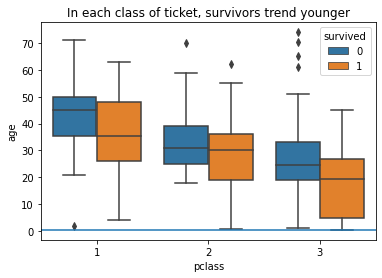

In [29]:
# At each class ticket, women have better survival rates
plt.title("In each class of ticket, survivors trend younger")
sns.boxplot(x="pclass", y="age", data=train, hue="survived")
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate)
plt.show()

In [32]:
# are there enough 1st class passengers to draw conclusions?
train[train.pclass == 1].survived.value_counts()

1    72
0    36
Name: survived, dtype: int64

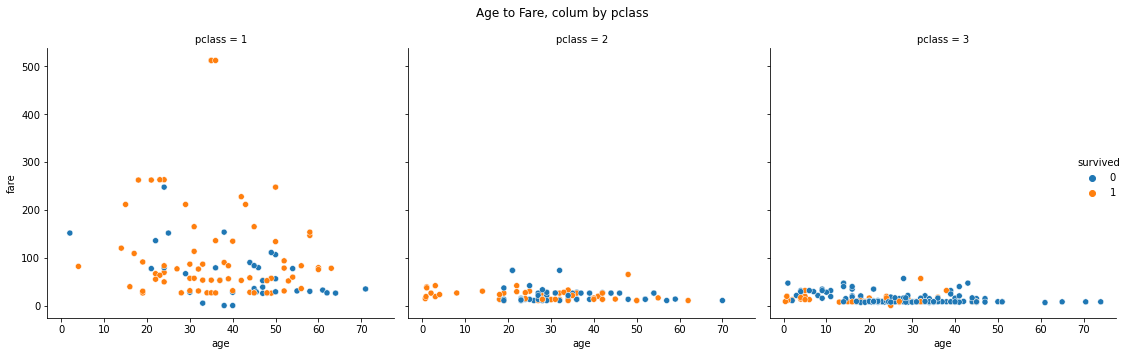

In [33]:
# No discernable relationship between age and fare, but the pclass relates to survival
rel = sns.relplot(x='age', y='fare', data=train, col="pclass", hue="survived")
rel.fig.suptitle('Age to Fare, colum by pclass') # One way to title a relplot
plt.tight_layout()

In [34]:
# fare and age don't seem to relate
# however, the more people paid, the more orange we see

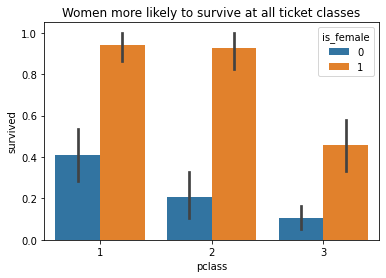

In [35]:
plt.title("Women more likely to survive at all ticket classes")
sns.barplot(x="pclass", y="survived", hue="is_female", data=train)
population_survival_rate = train.survived.mean()
plt.show()

In [37]:
women_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 1)]
men_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 0)]

print(f"Overall survival rate:", round(train.survived.mean(), 2))
print(f"Overall female survival rate", round(train[train.is_female == 1].survived.mean(), 2))
print(f"Overall male survival rate", round(train[train.is_female == 0].survived.mean(), 2))
print(f"3rd class ticket survival rate", round(train[train.pclass == 3].survived.mean(), 2))
print(f"Survival rate for women in 3rd class:", round(women_in_3rd_class.survived.mean(), 2))
print(f"Survival rate for men in 3rd class:", round(men_in_3rd_class.survived.mean(), 2))

Overall survival rate: 0.4
Overall female survival rate 0.75
Overall male survival rate 0.2
3rd class ticket survival rate 0.21
Survival rate for women in 3rd class: 0.46
Survival rate for men in 3rd class: 0.1


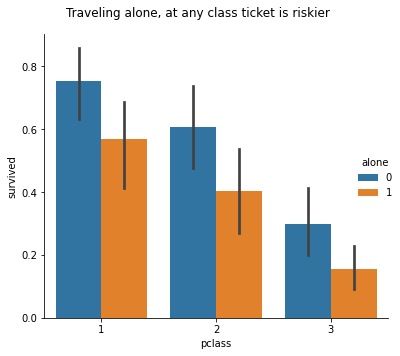

In [38]:
cat = sns.catplot(data=train, x="pclass", y="survived", hue="alone", kind="bar")
cat.fig.suptitle("Traveling alone, at any class ticket is riskier")
plt.tight_layout()